# Решение кейса "ML для оценки параметров экономических моделей" команды С_кайфом!_Squad

Разработанное решение представляет собой несколько рекуррентных нейронных сетей, отображающих смоделированные временные ряды в модельные параметры. Использование нескольких "черных ящиков" призвано точнее приблизить стохастический характер эволюции исходной системы. Последующий анализ нескольких массивов значений на основе Байесовской статистики позволяет аппроксимировать априорные распределения параметров.

### Импорт необходимых библиотек

In [ ]:
import tensorflow as tf
import numpy as np

### Загрузка и оценка данных

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=5)
X = np.load('train_x.npy')
Y = np.load('train_y.npy')

Для беглой оценки исходных данных построим гистограммы для каждого параметра:

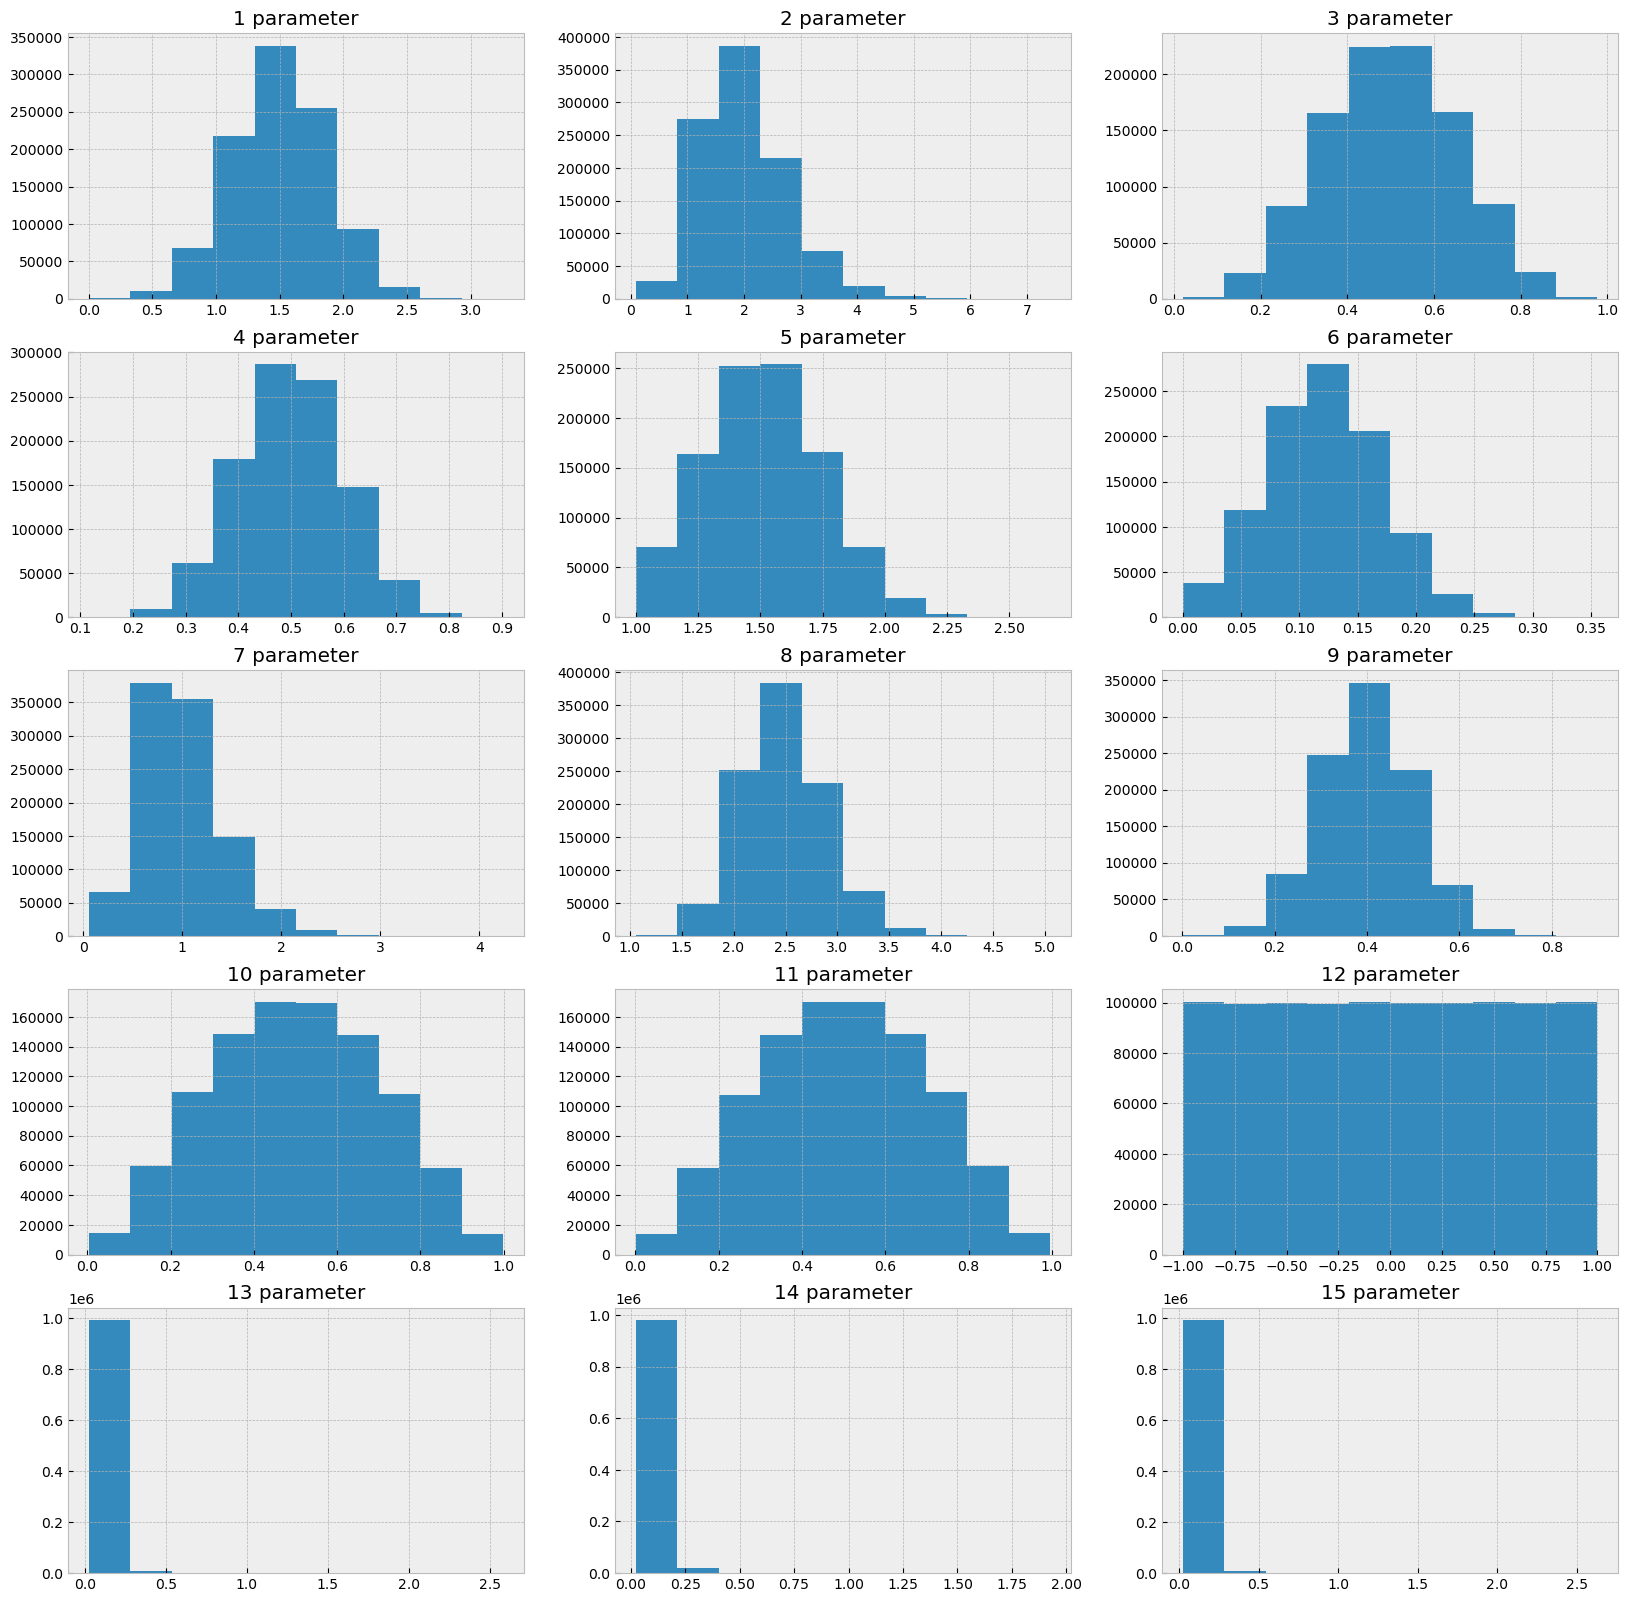

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
plt.style.use(['bmh'])
fig, ax = plt.subplots(5,3,figsize=(20,20),dpi=100)
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.hist(goal[:,i])
    ax.set_title(f'{i+1} parameter')
    # ax.legend(loc='best')
plt.show()

Таким образом мы перепроверяем данные на соответствие справочной информации о распределении (без учета множителей и логарифмов), каждое соответствует описанному: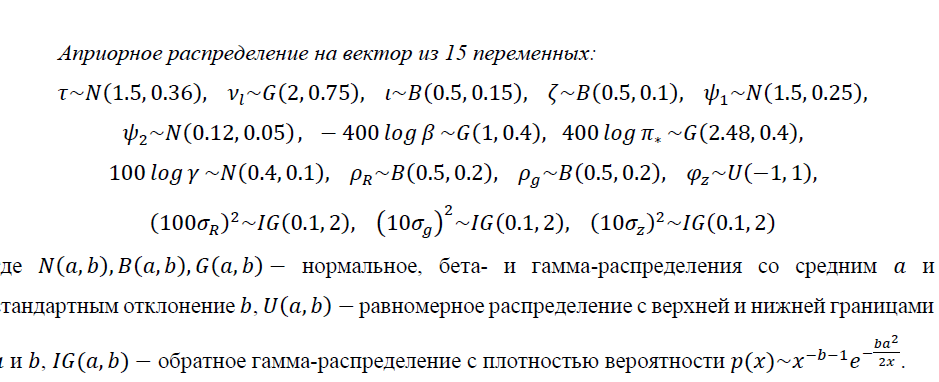

Кроме того, это наблюдение будет использовано в финальном статистическом анализе. Сформируем датасет на основе исходны данных для фреймворка TensorFlow:

In [ ]:
with tf.device('GPU'):
    train_dataset = (tf.data.Dataset.from_tensor_slices(
            (tf.cast(x_train, tf.float64),
             tf.cast(y_train, tf.float64))))
    BUFFER_SIZE = 10000
    BATCH_SIZE = 128
    del x_train,y_train
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
Y = np.load('test_y.npy')
with tf.device('GPU'):
    test_dataset = (tf.data.Dataset.from_tensor_slices(
            (tf.cast(np.load('test_x.npy'), tf.float64),
             tf.cast(Y, tf.float64))))
    del Y
    test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

## Модель 1

Все предложенные модели являются вариациями рекуррентных нейронных сетей, доказавших свою пригодность к анализу временных рядов. В зависимости от модели варьируется количество скрытых слоев, их размерность и тип.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
])
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
with tf.device('GPU'):
    model.build((None, 200, 3))
    model.compile(optimizer='sgd', loss=mse)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 512)               532480    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 600079 (2.29 MB)
Trainable params: 600079 (2.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('GPU'):
    history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
5469/5469 [==============================] - 251s 46ms/step - loss: 63.6530 - val_loss: 31.5985
Epoch 2/10
5469/5469 [==============================] - 253s 46ms/step - loss: 19.7914 - val_loss: 4.6973
Epoch 3/10
5469/5469 [==============================] - 253s 46ms/step - loss: 9.0960 - val_loss: 4.4894
Epoch 4/10
5469/5469 [==============================] - 254s 46ms/step - loss: 8.7741 - val_loss: 4.4042
Epoch 5/10
5469/5469 [==============================] - 253s 46ms/step - loss: 8.5653 - val_loss: 4.3359
Epoch 6/10
5469/5469 [==============================] - 253s 46ms/step - loss: 8.4205 - val_loss: 4.2942
Epoch 7/10
5469/5469 [==============================] - 253s 46ms/step - loss: 8.3071 - val_loss: 4.2372
Epoch 8/10
5469/5469 [==============================] - 253s 46ms/step - loss: 8.2109 - val_loss: 4.1786
Epoch 9/10
5469/5469 [==============================] - 252s 46ms/step - loss: 8.1324 - val_loss: 4.1643
Epoch 10/10
5469/5469 [=============================

In [ ]:
model.compile(optimizer='sgd', loss=mse,metrics=[tf.keras.metrics.MeanAbsoluteError()])
with tf.device('GPU'):
    history = model.fit(train_dataset, epochs=5,validation_data=test_dataset,validation_steps=30)

Epoch 1/5
5469/5469 [==============================] - 257s 46ms/step - loss: 7.9614 - mean_absolute_error: 0.1357 - root_mean_squared_error: 0.0000e+00 - val_loss: 4.0995 - val_mean_absolute_error: 0.1367 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/5
5469/5469 [==============================] - 256s 47ms/step - loss: 7.9076 - mean_absolute_error: 0.1350 - root_mean_squared_error: 0.0000e+00 - val_loss: 4.0335 - val_mean_absolute_error: 0.1349 - val_root_mean_squared_error: 0.0000e+00
Epoch 3/5
5469/5469 [==============================] - 255s 47ms/step - loss: 7.8564 - mean_absolute_error: 0.1344 - root_mean_squared_error: 0.0000e+00 - val_loss: 4.0161 - val_mean_absolute_error: 0.1344 - val_root_mean_squared_error: 0.0000e+00
Epoch 4/5
5469/5469 [==============================] - 255s 47ms/step - loss: 7.8016 - mean_absolute_error: 0.1338 - root_mean_squared_error: 0.0000e+00 - val_loss: 3.9694 - val_mean_absolute_error: 0.1336 - val_root_mean_squared_error: 0.0000e+00
Epoch 5/

In [ ]:
model.save_weights('./weight/tf_RNN_7_checkpoint', save_format='tf')
model.save('/RNN_mse_7_tf/')

## Модель 2

In [ ]:
model_1 = tf.keras.saving.load_model(
    '/RNN_mse_6_tf/',
    custom_objects=None, compile=True, safe_mode=True,)

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 512)               532480    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 15)                975       
                                                                 
Total params: 566287 (2.16 MB)
Trainable params: 566287 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('GPU'):
    history = model_1.fit(train_dataset, epochs=10,validation_steps=30)

Epoch 1/10
5469/5469 [==============================] - 251s 45ms/step - loss: 11.8050
Epoch 2/10
5469/5469 [==============================] - 252s 46ms/step - loss: 8.4966
Epoch 3/10
5469/5469 [==============================] - 252s 46ms/step - loss: 7.9033
Epoch 4/10
5469/5469 [==============================] - 252s 46ms/step - loss: 7.5208
Epoch 5/10
5469/5469 [==============================] - 252s 46ms/step - loss: 7.2738
Epoch 6/10
5469/5469 [==============================] - 253s 46ms/step - loss: 7.1074
Epoch 7/10
5469/5469 [==============================] - 252s 46ms/step - loss: 6.9824
Epoch 8/10
5469/5469 [==============================] - 252s 46ms/step - loss: 6.8871
Epoch 9/10
5469/5469 [==============================] - 259s 47ms/step - loss: 6.8019
Epoch 10/10
5469/5469 [==============================] - 255s 47ms/step - loss: 6.7242


## Модель 3

In [ ]:
import keras
from keras import layers

model_3 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),
    tf.keras.layers.Dense(600, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
])

mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
with tf.device('GPU'):
    model_3.build((None, 200, 3))
    model_3.compile(optimizer='adam', loss=mse)
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 600)               729600    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 600)               360600    
                                                                 
 dense_4 (Dense)             (None, 300)               180300    
                                                                 
 dense_5 (Dense)             (None, 15)                4515      
                                                                 
Total params: 1275015 (4.86 MB)
Trainable params: 1275015 (4.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('GPU'):
    history = model_3.fit(train_dataset, epochs=5,validation_data=test_dataset,validation_steps=30)

Epoch 1/5
5469/5469 [==============================] - 367s 67ms/step - loss: 5.4114 - val_loss: 2.9571
Epoch 2/5
5469/5469 [==============================] - 364s 67ms/step - loss: 5.3625 - val_loss: 3.0093
Epoch 3/5
5469/5469 [==============================] - 365s 67ms/step - loss: 5.3134 - val_loss: 3.0422
Epoch 4/5
5469/5469 [==============================] - 365s 67ms/step - loss: 5.2613 - val_loss: 3.0396
Epoch 5/5
5469/5469 [==============================] - 367s 67ms/step - loss: 5.2192 - val_loss: 3.0307


In [ ]:
model_3.save_weights('./weights_adam(5,2)')
model_3.save('/model_adam(5,2))/')

In [ ]:
x_test = np.load('/y_smp_test.npy')
with tf.device('GPU'):
    val_dataset = (tf.data.Dataset.from_tensor_slices(
            (tf.cast(x_test, tf.float64))))
    BUFFER_SIZE = 10000
    BATCH_SIZE = 128
val = val_dataset.batch(64)
Y = model_3.predict(val,verbose=2)

1563/1563 - 23s - 23s/epoch - 15ms/step


## Модель 4

In [ ]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.LSTM(512,return_sequences=True),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(15),
])
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
with tf.device('GPU'):
    model_4.build((None, 200, 3))
    model_4.compile(optimizer='adam', loss=mse, metrics=[tf.keras.metrics.MeanAbsoluteError()])
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 512)          1056768   
                                                                 
 gru (GRU)                   (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 1682959 (6.42 MB)
Trainable params: 1682959 (6.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('GPU'):
    history = model_4.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
5469/5469 [==============================] - 571s 103ms/step - loss: 6.2974 - mean_absolute_error: 0.1220 - val_loss: 2.5686 - val_mean_absolute_error: 0.1053
Epoch 2/10
5469/5469 [==============================] - 563s 103ms/step - loss: 4.7510 - mean_absolute_error: 0.1001 - val_loss: 2.4603 - val_mean_absolute_error: 0.1023
Epoch 3/10
5469/5469 [==============================] - 562s 103ms/step - loss: 4.4934 - mean_absolute_error: 0.0957 - val_loss: 2.3064 - val_mean_absolute_error: 0.0955
Epoch 4/10
5469/5469 [==============================] - 559s 102ms/step - loss: 4.3443 - mean_absolute_error: 0.0933 - val_loss: 2.2853 - val_mean_absolute_error: 0.0949
Epoch 5/10
5469/5469 [==============================] - 559s 102ms/step - loss: 4.2424 - mean_absolute_error: 0.0918 - val_loss: 2.2495 - val_mean_absolute_error: 0.0926
Epoch 6/10
5469/5469 [==============================] - 560s 102ms/step - loss: 4.1631 - mean_absolute_error: 0.0908 - val_loss: 2.2208 - val_mean_abs

In [ ]:
val = val_dataset.batch(128)

In [ ]:
x_test = np.load('/content/drive/MyDrive/Colab Notebooks/Digital/part_/y_smp_test.npy')

In [ ]:
with tf.device('GPU'):
    val_dataset = (tf.data.Dataset.from_tensor_slices(
            (tf.cast(x_test, tf.float64))))
    BUFFER_SIZE = 10000
    BATCH_SIZE = 128
    del x_test
val = val_dataset.batch(64)

In [ ]:
Y1 = model_1.predict(val,verbose=2)

1563/1563 - 18s - 18s/epoch - 11ms/step


In [ ]:
Y2 = model_2.predict(val,verbose=2)

1563/1563 - 18s - 18s/epoch - 12ms/step


In [ ]:
Y4 = model_4.predict(val,verbose=2)

782/782 - 28s - 28s/epoch - 36ms/step


In [ ]:
Y.shape,Y1.shape

((100000, 15), (100000, 15))

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/Digital/part_/result/res',rnn_6=Y,rnn_7=Y1,rnn_4=Y4)

[Ссылка на сохраненные веса](https://drive.google.com/drive/folders/1G-EvUHqFu5yZxnYzrxAFdJrotvTEEziJ?usp=drive_link)